In [1]:
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import subprocess #run R code from subprocess
import numpy as np
from os import listdir # get dir list
from os.path import isfile, join # get dir list


import concurrent.futures
import time
import pickle
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset') }
metabasesRanking = {'DT': pd.read_csv('Metabases/Metabase_DT.csv.zip', index_col='Dataset'), 'RF': pd.read_csv('Metabases/Metabase_RF.csv.zip', index_col='Dataset'), 'KNN': pd.read_csv('Metabases/Metabase_KNN.csv.zip', index_col='Dataset'),
'SVM': pd.read_csv('Metabases/Metabase_SVM.csv.zip', index_col='Dataset') }
DTCols = metabasesRanking['DT'].iloc[:,97:].columns

cols = ['Edge5', 'Edge20', 'HARF85', 'Hybrid', 'Edge15', 'OR3', 'GE9', 'AENN7',
       'HARF75', 'OR19', 'AENN11', 'AENN9', 'OR11', 'PRISM', 'GE3', 'GE7',
       'OR15', 'Dynamic', 'Edge10', 'HARF80', 'AENN3', 'HARF90', 'OR7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
for i in metabasesRanking:
    metabasesRanking[i] = metabasesRanking[i][DTCols]
    metabasesRanking[i].columns = cols

for i in metabasesRanking:
    noFilterResults = pd.read_csv(f'Results/NoisyDatasets_results{i}.csv.zip', index_col='Unnamed: 0')
    noFilterResults = noFilterResults.rename(columns={'test_f1_macro_mean': 'noFilterResults'})
    noFilterResults.index.name='Dataset'
    metabasesRanking[i]['noFilterResults'] = noFilterResults['noFilterResults'].sort_index()

gain = {}
for i in metabasesRanking:
    gain[i] = metabasesRanking[i].sub(metabasesRanking[i]['noFilterResults'], axis=0)
    gain[i].drop('noFilterResults', axis = 1, inplace = True)

In [3]:
RFPredictRank = pd.read_csv('RankingResults/results_RF_f1-score-DT.csv.zip', index_col='Dataset')

if os.path.isfile('PickleVars/09- friedmantest/rank2.p'):
    file = open('PickleVars/09- friedmantest/rank2.p', 'rb')
    rank2 = pickle.load(file)
    file.close()
else:
    rank2 = pd.DataFrame()
    for i, a in enumerate(RFPredictRank.index):
        rank2 = rank2.append(RFPredictRank.iloc[i].rank(method = 'dense', ascending = False))
    file = open('PickleVars/09- friedmantest/rank2.p', 'wb')
    pickle.dump(rank2, file)
    file.close()

meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
fixedCols = meta_data.columns
fixedCols2 = ['test_f1_macro_mean_AENN-5', 'test_f1_macro_mean_edgeBoostFilter-15','test_f1_macro_mean_PRISM', 'test_f1_macro_mean_HARF-70',
       'test_f1_macro_mean_GE-5', 'test_f1_macro_mean_dynamicCF','test_f1_macro_mean_hybridRepairFilter','test_f1_macro_mean_ORBoost-11']

def computeMethodGain(predictRankResult, fixedCols, gaindf):
    rank = pd.DataFrame()
    df = predictRankResult[fixedCols]
    for i, a in enumerate(df.index):
        rank = rank.append(df.iloc[i].rank(method = 'dense', ascending = False))
    total = []
    rank = rank[fixedCols]
    if len(fixedCols)>20:
        rank.columns = ['Edge5', 'Edge20', 'HARF85', 'Hybrid', 'Edge15', 'OR3', 'GE9', 'AENN7',
       'HARF75', 'OR19', 'AENN11', 'AENN9', 'OR11', 'PRISM', 'GE3', 'GE7',
       'OR15', 'Dynamic', 'Edge10', 'HARF80', 'AENN3', 'HARF90', 'OR7',
       'HARF70', 'GE5', 'AENN5', 'GE11']
    else:
        rank.columns = [ 'AENN5', 'Edge15', 'PRISM', 'HARF70', 'GE5', 'Dynamic', 'Hybrid', 'OR11']
    for index, value  in enumerate(rank.idxmin(axis =1)):
        total.append(gaindf[value].iloc[index])
    return total
predictRankResult = pd.read_csv('RankingResults/results_RF_f1-score-RF.csv.zip', index_col='Dataset')
total = computeMethodGain(predictRankResult, fixedCols2, gain['RF'])


In [4]:
def getFolderFilesList(path):
    return [filename for filename in listdir(path) if isfile(join(path, filename))]
resultNameList = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('RankingResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)

resultNameList

gainMetabase = None
usedCols = None
MtLRankingGain = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/09- friedmantest/MtLRankingGain.p'):
    file = open('PickleVars/09- friedmantest/MtLRankingGain.p', 'rb')
    MtLRankingGain = pickle.load(file)
    file.close()
else:
    for i in resultNameList:
        for resultFileName in resultNameList[i]:
            predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLRankingGain[i][f'MtL-Rank-RF'] = computeMethodGain(predictRankResult, usedCols, gain[i])
            if '_GB'in resultFileName:
                MtLRankingGain[i][f'MtL-Rank-GB'] = computeMethodGain(predictRankResult, usedCols, gain[i])
            if '_KNN'in resultFileName:
                MtLRankingGain[i][f'MtL-Rank-KNN'] = computeMethodGain(predictRankResult, usedCols, gain[i])

    file = open('PickleVars/09- friedmantest/MtLRankingGain.p', 'wb')
    pickle.dump(MtLRankingGain, file)
    file.close()
MtLRankingGain

{'RF': {'MtL-Rank-RF': [0.4224302896881672,
   0.29750259888952557,
   0.45221052272226825,
   0.22316238504913,
   0.45288997669896913,
   0.4628740406306534,
   0.3582117870685818,
   0.3166034743783359,
   0.40189282658353964,
   0.38030224124342005,
   0.5111264233749688,
   0.4697194099255614,
   0.4396579492562714,
   0.4777558276592232,
   0.5065324190044684,
   0.4824549531393032,
   0.4447260542371807,
   0.6012767805506966,
   0.5166940357790507,
   0.45110221073656065,
   0.2803547330026279,
   0.2919717671633868,
   0.28425451644502475,
   0.2494380507941769,
   0.2936354919103161,
   0.2075476992537485,
   0.13498474786605075,
   0.2473492606615031,
   0.26299598509071864,
   0.2867836972185467,
   0.19702590911550177,
   0.13376794075710408,
   0.1984548249864675,
   0.175170034526691,
   0.25160256412459425,
   0.23156257746429065,
   0.2106885684959272,
   0.18239162171516787,
   0.2354440848071031,
   0.2789727590417248,
   0.31236551788252975,
   0.2179429902387061,
 

In [5]:
gainMetabase = None
usedCols = None
MtLRankingGainNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None
if os.path.isfile('PickleVars/09- friedmantest/MtLRankingGainNoHyper.p'):
    file = open('PickleVars/09- friedmantest/MtLRankingGainNoHyper.p', 'rb')
    MtLRankingGainNoHyper = pickle.load(file)
    file.close()
else:
    for i in resultNameListNoHyper:
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'RankingResults/{resultFileName}', index_col='Dataset')
            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-Rank-RF'] = computeMethodGain(predictRankResult, usedCols, gain[i])
            if '_GB'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-Rank-GB'] = computeMethodGain(predictRankResult, usedCols, gain[i])
            if '_KNN'in resultFileName:
                MtLRankingGainNoHyper[i][f'MtL-Rank-KNN'] = computeMethodGain(predictRankResult, usedCols, gain[i])
        
    file = open('PickleVars/09- friedmantest/MtLRankingGainNoHyper.p', 'wb')
    pickle.dump(MtLRankingGainNoHyper, file)
    file.close()
MtLRankingGainNoHyper

{'RF': {'MtL-Rank-KNN': [0.44948523893019976,
   0.29750259888952557,
   0.45221052272226825,
   0.22316238504913,
   0.45288997669896913,
   0.4628740406306534,
   0.3582117870685818,
   0.31119413917994265,
   0.2911963203462353,
   0.38030224124342005,
   0.5111264233749688,
   0.16370015051625153,
   0.4857262977938895,
   0.4925311430165378,
   0.4806706959013289,
   0.4621983446142426,
   0.4447260542371807,
   0.41287946599061287,
   0.5166940357790507,
   0.46449243744884294,
   0.2990353460542755,
   0.2823597446972952,
   0.22551303668324585,
   0.2494380507941769,
   0.29294705482629435,
   0.2075476992537485,
   0.13498474786605075,
   0.2448747629547965,
   0.24865551627126747,
   0.2867836972185467,
   0.09431709743610195,
   0.19210769469892752,
   0.1984548249864675,
   0.1906640033265069,
   0.25160256412459425,
   0.13852781310204865,
   0.1432921928830998,
   0.18239162171516787,
   0.2354440848071031,
   0.24461354017687376,
   0.28433861000859795,
   0.217942990238

In [6]:
from scipy import stats
import scikit_posthocs as sp

(stats.studentized_range.ppf(0.05, 4, 13*4))/2**(1/2)
k = 4
alpha = 0.05
N = 10740
t_range = stats.studentized_range.ppf(1-alpha, k, (N-1)*(k-1))
q_alfa = (3.633/(2**(1/2))) 
s = ( ((k*(k-1))/(6*N)) )**(1/2)
(3.633/(2**(1/2))) *(( ((4*3)/(6*10740)) )**(1/2))
# display((( ((4*3)/(6*10740)) )**(1/2)))
# display(s)

CD = q_alfa * s
CD

0.03505607240251684

In [10]:
# k = 4
# alpha = 0.05

# # Calculate the critical value q from the Student's t-distribution
# q = stats.t.ppf(1 - alpha / 2, k - 1)
# display(q)
# # Define the number of data points
# n = 10740

df = pd.DataFrame()
for i in gain:

    # stats.friedmanchisquare(MtLRankingGain[i]['MtL-RF'], MtLRankingGain[i]['MtL-GB'], MtLRankingGain[i]['MtL-KNN'], gain[i]['Dynamic'].values)
    # q = stats.chi2.ppf(q=0.95, df=10739*3)
    # CD = (q/(2**2)) *((k*(k-1))/6*n)
    # display (CD)
    df[i] = (pd.DataFrame([MtLRankingGain[i]['MtL-Rank-RF'], MtLRankingGain[i]['MtL-Rank-GB'], MtLRankingGain[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values], index=['RF', 'GB', 'KNN', 'DCF']).T).rank(axis=1, method = 'dense', ascending = False).mean()
df = df.T
df.columns = ['MtL-RF','MtL-GB', 'MtL-KNN', 'DCF']
display(df)

df1 = pd.DataFrame()
for i in gain:
    
    df1[i] = (pd.DataFrame([MtLRankingGainNoHyper[i]['MtL-Rank-RF'], MtLRankingGainNoHyper[i]['MtL-Rank-GB'], MtLRankingGainNoHyper[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values], index=['RF', 'GB', 'KNN', 'DCF']).T).rank(axis=1, method = 'dense', ascending = False).mean()
df1 = df1.T
df1.columns = ['MtL-RF','MtL-GB', 'MtL-KNN', 'DCF']
display(df1)

,MtL-RF,MtL-GB,MtL-KNN,DCF
DT,1.444693,1.520205,1.648976,1.545717
RF,1.507728,1.599255,1.706611,1.646182
KNN,1.648231,1.721695,1.910894,1.996927
SVM,1.652048,1.766201,1.860428,1.946462


,MtL-RF,MtL-GB,MtL-KNN,DCF
DT,1.277281,1.326071,1.427654,1.286685
RF,1.286778,1.364618,1.437709,1.325605
KNN,1.453073,1.545438,1.702235,1.651583
SVM,1.492179,1.590317,1.674395,1.629516


In [11]:

from scipy import stats
import scikit_posthocs as sp
import numpy as np
 
for i in gain:
        
    b = stats.friedmanchisquare(MtLRankingGain[i]['MtL-Rank-RF'], MtLRankingGain[i]['MtL-Rank-GB'], MtLRankingGain[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values)
    
    # Combine three groups into one array
    data = np.array([MtLRankingGain[i]['MtL-Rank-RF'], MtLRankingGain[i]['MtL-Rank-GB'], MtLRankingGain[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values])
    
    # Conduct the Nemenyi post-Rank-hoc testa
    a = sp.posthoc_nemenyi_friedman(data.T)
    a.columns = ['RF','GB', 'KNN', 'DCF']
    a.index = a.columns
    display(a)

for i in gain:
        
    b = stats.friedmanchisquare(MtLRankingGainNoHyper[i]['MtL-Rank-RF'], MtLRankingGainNoHyper[i]['MtL-Rank-GB'], MtLRankingGainNoHyper[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values)
    
    # Combine three groups into one array
    data = np.array([MtLRankingGainNoHyper[i]['MtL-Rank-RF'], MtLRankingGainNoHyper[i]['MtL-Rank-GB'], MtLRankingGainNoHyper[i]['MtL-Rank-KNN'], gain[i]['Dynamic'].values])
    
    # Conduct the Nemenyi post-hoc testa
    a = sp.posthoc_nemenyi_friedman(data.T)
    a.columns = ['RF','GB', 'KNN', 'DCF']
    a.index = a.columns
    display(a)

,RF,GB,KNN,DCF
RF,1.000,0.001000,0.001,0.001000
GB,0.001,1.000000,0.001,0.091597
KNN,0.001,0.001000,1.000,0.001000
DCF,0.001,0.091597,0.001,1.000000


,RF,GB,KNN,DCF
RF,1.000,0.00100,0.001,0.00100
GB,0.001,1.00000,0.001,0.00153
KNN,0.001,0.00100,1.000,0.00100
DCF,0.001,0.00153,0.001,1.00000


,RF,GB,KNN,DCF
RF,1.000,0.001,0.001,0.001
GB,0.001,1.000,0.001,0.001
KNN,0.001,0.001,1.000,0.001
DCF,0.001,0.001,0.001,1.000


,RF,GB,KNN,DCF
RF,1.000,0.001,0.001,0.001
GB,0.001,1.000,0.001,0.001
KNN,0.001,0.001,1.000,0.001
DCF,0.001,0.001,0.001,1.000


,RF,GB,KNN,DCF
RF,1.000000,0.001000,0.001,0.460704
GB,0.001000,1.000000,0.001,0.001799
KNN,0.001000,0.001000,1.000,0.001000
DCF,0.460704,0.001799,0.001,1.000000


,RF,GB,KNN,DCF
RF,1.000,0.001000,0.001,0.001000
GB,0.001,1.000000,0.001,0.002662
KNN,0.001,0.001000,1.000,0.001000
DCF,0.001,0.002662,0.001,1.000000


,RF,GB,KNN,DCF
RF,1.000,0.001,0.001,0.001
GB,0.001,1.000,0.001,0.001
KNN,0.001,0.001,1.000,0.001
DCF,0.001,0.001,0.001,1.000


,RF,GB,KNN,DCF
RF,1.000,0.001,0.001000,0.001000
GB,0.001,1.000,0.001000,0.001000
KNN,0.001,0.001,1.000000,0.492596
DCF,0.001,0.001,0.492596,1.000000


In [9]:
# df = df.T
df.iloc[[3,2, 1, 0]]

,MtL-Rank-RF,MtL-Rank-GB,MtL-Rank-KNN,DCF
SVM,1.652048,1.766201,1.860428,1.946462
KNN,1.648231,1.721695,1.910894,1.996927
RF,1.507728,1.599255,1.706611,1.646182
DT,1.444693,1.520205,1.648976,1.545717


In [14]:
import plotly.express as px
import plotly.graph_objects as go
# df = px.data.iris()
def plotNemenyiDualGraph(df, df1):
    fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.085,
                    horizontal_spacing=0.085,
                    x_title='Nemenyi test',
                    y_title='Base-Learner',
                    subplot_titles=('With Hyperparameters',  'Without Hyperparameters'))
    for i in df.columns:
        fig.add_trace(go.Scatter(x=df[i], y=df.index,
                            mode='markers',
                            name=i,
                            error_x=dict(
                                type='data',
                                symmetric=False,
                                array=[CD, CD, CD, CD])
            ), col =1, row=1)
    count = 0
    for i in df1.columns:
        fig.add_trace(go.Scatter(x=df1[i], y=df1.index,
                            mode='markers',
                            name=i,
                            error_x=dict(
                                type='data',
                                symmetric=False,
                                array=[CD, CD, CD, CD]),
                            showlegend=False,
                            marker_color = plotly.colors.qualitative.Plotly[count]
            ), col =1, row=2)
        count +=1
    # fig = px.scatter(df1, y=df1.columns, x=df1.index[1], color=df1.index)
    # fig.add_scatter(df1, y=df1.index, x='MtL-RF', color=df1.columns)
    fig.update_layout(
    legend_title="Method:",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
    annotations=[
        go.layout.Annotation(
            {
                "font": dict(
                    # family="Courier New, monospace",
                    size=16,
                    # color="#ffffff"
                    ),

            })
        ],
        font=dict(
            size=16,
        ),
        yaxis = dict(
            tickfont = dict(size=16)),
        xaxis = dict(
            tickfont = dict(size=16))
    )
    fig.show(renderer="png", width=1300,
                height=700)


def plotNemenyiGraph(df):
    fig = go.Figure()
    for i in df.columns:
        fig.add_trace(go.Scatter(x=df[i], y=df.index,
                            mode='markers',
                            name=i,
                            error_x=dict(
                                type='data',
                                symmetric=False,
                                array=[CD, CD, CD, CD])
            ))
    
    fig.update_layout(
        legend_title="Method:",
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
        ),
        autosize=False,
        width=800,
        height=1000,
        yaxis=dict(
            title_text="Base-Learner",
            titlefont=dict(size=20),
        ),
        xaxis=dict(
            title_text="Nemenyi test",
            titlefont=dict(size=20),
        ),
        font=dict(
            size=20,
        )
    )
    fig.show(renderer="png", width=1000,
                height=400)

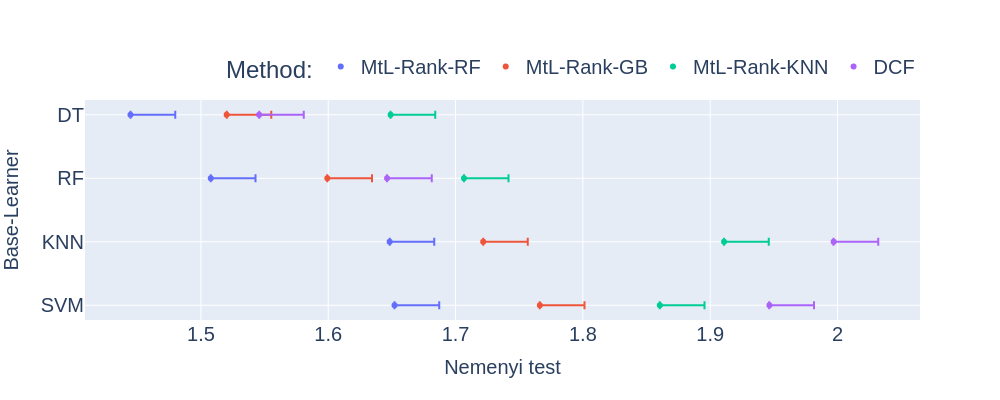

In [13]:
plotNemenyiGraph( df.iloc[[3,2, 1, 0]])

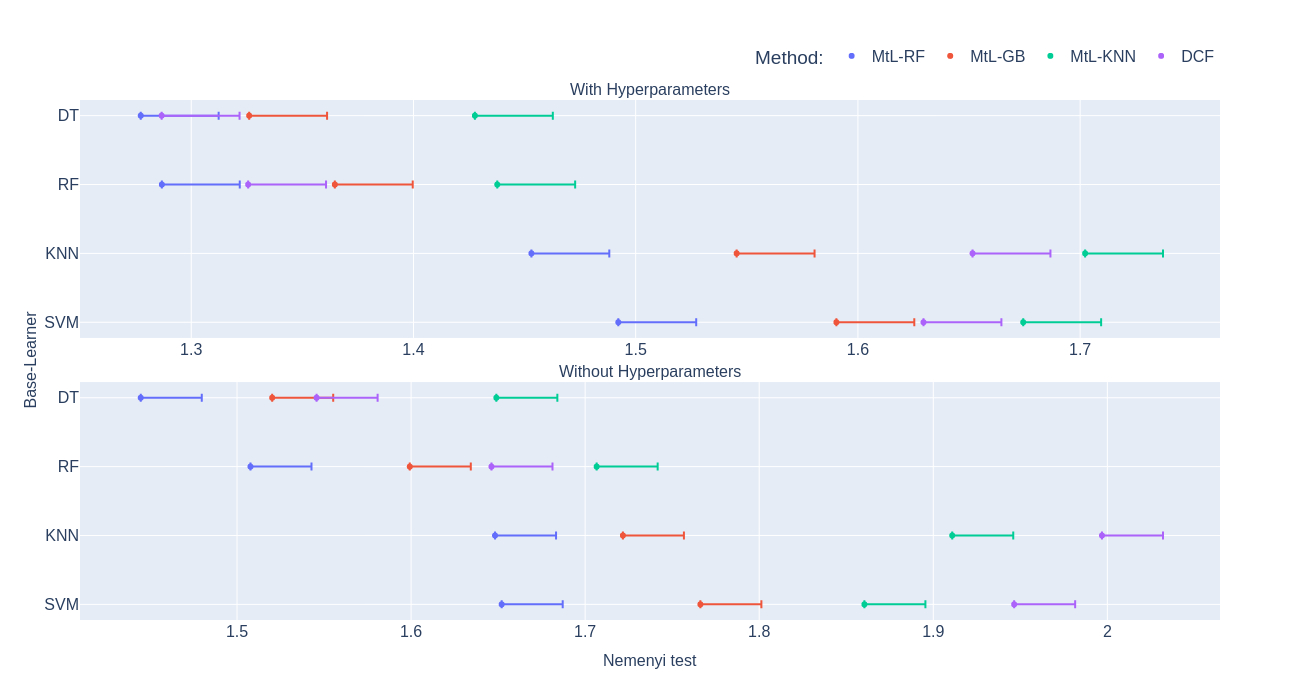

In [15]:
plotNemenyiDualGraph(df1.iloc[[3,2, 1, 0]], df.iloc[[3,2, 1, 0]])

# MtL-Multi

In [14]:
def returnSelectedAlgorithms(df = None):
    best_algo ={}
    for index, row in df.iterrows():
        best_algo[index] = row[f'Best{row["BestType"]}Algo']
        if best_algo[index] == 'ORBoost':
            best_algo[index] = row['BestOR']
        if best_algo[index] == 'AENN':
            best_algo[index] = row['BestAenn']
        if best_algo[index] == 'GE':
            best_algo[index] = row['BestGE']
        if best_algo[index] == 'HARF':
            best_algo[index]= row['BestHARF']
        if best_algo[index] == 'Edge':
            best_algo[index] = row['BestEdge']
    return pd.DataFrame.from_dict(best_algo, orient= 'index', columns=["SelectedAlgo"])

def returnSelectedAlgorithmsNoHyper(df = None):
    best_algo ={}
    for index, row in df.iterrows():
        best_algo[index] = row[f'Best{row["BestType"]}Algo']
    return pd.DataFrame.from_dict(best_algo, orient= 'index', columns=["SelectedAlgo"])


def getBestAlgorithmsListNoHyper(metabase):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    meta_data.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15',  'OR3','GE9', 'AENN7',
        'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
        'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
        'GE5', 'AENN5','GE11']
    meta_data = meta_data[['GE5', 'AENN5', 'HARF70', 'Edge15', 'PRISM', 'Hybrid',  'OR11', 'Dynamic']]
    meta_data.columns = ['GE', 'AENN', 'HARF', 'Edge', 'PRISM', 'Hybrid',  'ORBoost', 'Dynamic']

    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    # rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
    #    'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
    #    'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
    #    'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row == 1].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

def getBestAlgorithmsList(metabase):
    meta_data = pd.read_csv(f'Metabases/Metabase_DT.csv.zip', index_col='Dataset').iloc[:,97:]
    cols = meta_data.columns
    meta_data = pd.read_csv(f'Metabases/Metabase_{metabase}.csv.zip', index_col='Dataset')[cols]
    rank = pd.DataFrame()
    # meta_data.drop('test_f1_macro_mean_AENN',axis=1, inplace=True)
    for i, a in enumerate(meta_data.index):
        rank = rank.append(meta_data.iloc[i].rank(method = 'dense', ascending = False))
    
    rank.columns = ['Edge5','Edge20', 'HARF85','Hybrid', 'Edge15', 'OR3','GE9', 'AENN7',
       'HARF75', 'OR19','AENN11', 'AENN9','OR11', 'PRISM','GE3', 'GE7',
       'OR15', 'Dynamic','Edge10', 'HARF80','AENN3', 'HARF90','OR7', 'HARF70',
       'GE5', 'AENN5','GE11']

    bestAlgorithmsDict ={}
    bestAlgorithmsList = []
    for index, row in rank.iterrows():
        arr = list(row[row == 1].index)
        bestAlgorithmsDict[index] = arr
        bestAlgorithmsList.append(arr)
    return bestAlgorithmsList, bestAlgorithmsDict

In [15]:
# df = pd.read_csv(f'MultipleClassifierResults/results_Multiple_RF_f1-score-DT-Hyper.csv.zip', index_col='Dataset')
df = pd.read_csv(f'MultipleClassifierResults/results_Multiple_RF_f1-score-DT-Hyper.csv.zip', index_col='Dataset')
display (df)
df0 = returnSelectedAlgorithms(df)
bestalgoList, bestalgoDict =  getBestAlgorithmsList("DT")
df0['Best'] = bestalgoList
df0

,BestType,BestEnsambleAlgo,BestDistanceAlgo,BestVotingAlgo,BestAenn,BestGE,BestOR,BestEdge,BestHARF
Dataset,,,,,,,,,
1004_synthetic_control_10_0.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE9,OR3,Edge20,HARF70
1004_synthetic_control_10_1.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE9,OR3,Edge20,HARF70
1004_synthetic_control_10_2.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE11,OR7,Edge15,HARF70
1004_synthetic_control_10_3.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE9,OR3,Edge20,HARF70
1004_synthetic_control_10_4.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE9,OR7,Edge15,HARF70
...,...,...,...,...,...,...,...,...,...
997_balance-scale_5_5.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN9,GE11,OR3,Edge20,HARF70
997_balance-scale_5_6.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE9,OR3,Edge20,HARF70
997_balance-scale_5_7.csv.gz,Ensamble,ORBoost,AENN,Dynamic,AENN11,GE11,OR3,Edge20,HARF70


,SelectedAlgo,Best
1004_synthetic_control_10_0.csv.gz,OR3,[Edge5]
1004_synthetic_control_10_1.csv.gz,OR3,[HARF90]
1004_synthetic_control_10_2.csv.gz,OR7,[AENN11]
1004_synthetic_control_10_3.csv.gz,OR3,[GE11]
1004_synthetic_control_10_4.csv.gz,OR7,[GE7]
...,...,...
997_balance-scale_5_5.csv.gz,OR3,[HARF85]
997_balance-scale_5_6.csv.gz,OR3,[Edge20]
997_balance-scale_5_7.csv.gz,OR3,[Edge15]
997_balance-scale_5_8.csv.gz,Dynamic,[Edge15]


In [16]:
def getFolderFilesList(path):
    return [filename for filename in listdir(path) if isfile(join(path, filename))]
resultNameList = {'RF': [], 'DT': [], 'KNN': [],'SVM': []}
resultNameListNoHyper = {'RF': [], 'DT': [], 'KNN': [], 'SVM': []}
for i in getFolderFilesList('MultipleClassifierResults'):
    if i[-4:] == '.zip':
        if 'NoHyper' in i:
            if '-RF'in i:
                resultNameListNoHyper['RF'].append(i)
            if '-DT'in i:
                resultNameListNoHyper['DT'].append(i)
            if '-KNN'in i:
                resultNameListNoHyper['KNN'].append(i)
            if '-SVM'in i:
                resultNameListNoHyper['SVM'].append(i)
        else:
            if '-RF'in i:
                resultNameList['RF'].append(i)
            if '-DT'in i:
                resultNameList['DT'].append(i)
            if '-KNN'in i:
                resultNameList['KNN'].append(i)
            if '-SVM'in i:
                resultNameList['SVM'].append(i)
resultNameList

{'RF': ['results_Multiple_KNN_f1-score-RF-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-RF.csv.zip',
  'results_Multiple_RF_f1-score-RF-Hyper.csv.zip'],
 'DT': ['results_Multiple_RF_f1-score-DT-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-DT.csv.zip',
  'results_Multiple_KNN_f1-score-DT-Hyper.csv.zip'],
 'KNN': ['results_Multiple_GB_f1-score-KNN.csv.zip',
  'results_Multiple_KNN_f1-score-KNN-Hyper.csv.zip',
  'results_Multiple_RF_f1-score-KNN-Hyper.csv.zip'],
 'SVM': ['results_Multiple_KNN_f1-score-SVM-Hyper.csv.zip',
  'results_Multiple_RF_f1-score-SVM-Hyper.csv.zip',
  'results_Multiple_GB_f1-score-SVM.csv.zip']}

In [16]:
df0 [df0['SelectedAlgo'].isin(df0['Best'])]
arr = []
for index, row in df0.iterrows():
    arr.append(row['SelectedAlgo'] in row['Best'])
sum(arr)

391

In [17]:
gainMetabase = None
usedCols = None
MtLClassGain = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/09- friedmantest/MtLClassGain.p'):
    file = open('PickleVars/09- friedmantest/MtLClassGain.p', 'rb')
    MtLClassGain = pickle.load(file)
    file.close()
else:
    for i in resultNameList:
        for resultFileName in resultNameList[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithms(predictRankResult)
            df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            
            total = []
            for index, row in df0.iterrows():
                total.append(gain[i].loc[index][row['SelectedAlgo']])
            # df0['SelectedAlgo'].value_counts()
            total

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassGain[i][f'MtL-RF'] = total
            if '_GB'in resultFileName:
                MtLClassGain[i][f'MtL-GB'] = total
            if '_KNN'in resultFileName:
                MtLClassGain[i][f'MtL-KNN'] = total
    
    file = open('PickleVars/09- friedmantest/MtLClassGain.p', 'wb')
    pickle.dump(MtLClassGain, file)
    file.close()
display(MtLClassGain)

gainMetabase = None
usedCols = None
MtLClassGainNoHyper = {'RF': {}, 'DT': {}, 'KNN': {}, 'SVM': {}}
hypertype = None

if os.path.isfile('PickleVars/09- friedmantest/MtLClassGainNoHyper.p'):
    file = open('PickleVars/09- friedmantest/MtLClassGainNoHyper.p', 'rb')
    MtLClassGainNoHyper = pickle.load(file)
    file.close()
else:
    for i in resultNameListNoHyper:
        for resultFileName in resultNameListNoHyper[i]:
            predictRankResult = pd.read_csv(f'MultipleClassifierResults/{resultFileName}', index_col='Dataset')
            df0 = returnSelectedAlgorithmsNoHyper(predictRankResult)
            df0['SelectedAlgo'] = df0['SelectedAlgo'].replace(['ORBoost', 'Edge', 'HARF', 'GE', 'AENN', 'Prism'], ['OR11', 'Edge15', 'HARF70', 'GE5', 'AENN5', 'PRISM'])
            
            total = []
            for index, row in df0.iterrows():
                total.append(gain[i].loc[index][row['SelectedAlgo']])
            # df0['SelectedAlgo'].value_counts()
            total

            if 'NoHyper' in resultFileName:
                usedCols = fixedCols2
                hypertype = '-NoHyper'
            else:
                usedCols = fixedCols
                hypertype = ''
            if '_RF'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-RF'] = total
            if '_GB'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-GB'] = total
            if '_KNN'in resultFileName:
                MtLClassGainNoHyper[i][f'MtL-KNN'] = total

    file = open('PickleVars/09- friedmantest/MtLClassGainNoHyper.p', 'wb')
    pickle.dump(MtLClassGainNoHyper, file)
    file.close()
MtLClassGainNoHyper

{'RF': {'MtL-KNN': [0.4233526942333319,
   0.23409894083942107,
   0.45533959703778326,
   0.2297197589868476,
   0.45871447130311116,
   0.4628740406306534,
   0.3689460976772838,
   0.33138569634764126,
   0.31166189049058757,
   0.40586740344509076,
   0.477478474291499,
   0.4465994828969658,
   0.4933406308071477,
   0.45333954597278303,
   0.4806706959013289,
   0.48801411457266375,
   0.5171543552938982,
   0.6012767805506966,
   0.5166940357790507,
   0.47816765112405657,
   0.2827796367041274,
   0.2823597446972952,
   0.2887613828620036,
   0.28917316203872234,
   0.26990136412340515,
   0.237661534018746,
   0.13498474786605075,
   0.22163852044115728,
   0.26503877862154823,
   0.3148725070893149,
   0.02685867513872109,
   0.20877436136559424,
   0.24160751378792944,
   0.1989026718710225,
   0.2703177329463097,
   0.2126822053849987,
   0.0023984806843941886,
   0.18239162171516787,
   0.28238397414280847,
   0.2789727590417248,
   0.31236551788252975,
   0.21794299023870

{'RF': {'MtL-RF': [0.4224302896881672,
   0.29750259888952557,
   0.45221052272226825,
   0.22316238504913,
   0.45288997669896913,
   0.4628740406306534,
   0.3582117870685818,
   0.3166034743783359,
   0.40189282658353964,
   0.38030224124342005,
   0.5111264233749688,
   0.4697194099255614,
   0.4396579492562714,
   0.4777558276592232,
   0.5065324190044684,
   0.4824549531393032,
   0.4447260542371807,
   0.6012767805506966,
   0.5166940357790507,
   0.45110221073656065,
   0.2508374732148929,
   0.2823597446972952,
   0.25333578695811854,
   0.2494380507941769,
   0.2936354919103161,
   0.2075476992537485,
   0.13498474786605075,
   0.2473492606615031,
   0.24865551627126747,
   0.2867836972185467,
   -0.011303979986570734,
   0.19210769469892752,
   0.19518390296204147,
   0.1906640033265069,
   0.27834131855610234,
   0.2126822053849987,
   0.25532476840404716,
   0.2143833031898389,
   0.2518580697353252,
   0.2824137110044156,
   0.28433861000859795,
   0.24360084462035436,
  

In [18]:
df = pd.DataFrame()
for i in gain:

    # stats.friedmanchisquare(MtLRankingGain[i]['MtL-RF'], MtLRankingGain[i]['MtL-GB'], MtLRankingGain[i]['MtL-KNN'], gain[i]['Dynamic'].values)
    # q = stats.chi2.ppf(q=0.95, df=10739*3)
    # CD = (q/(2**2)) *((k*(k-1))/6*n)
    # display (CD)
    df[i] = (pd.DataFrame([MtLClassGain[i]['MtL-RF'], MtLClassGain[i]['MtL-GB'], MtLClassGain[i]['MtL-KNN'], gain[i]['Dynamic'].values], index=['RF', 'GB', 'KNN', 'DCF']).T).rank(axis=1, method = 'dense', ascending = False).mean()
df = df.T
df.columns = ['MtL-Multi-RF','MtL-Multi-GB', 'MtL-Multi-KNN', 'DCF']
display(df)

df1 = pd.DataFrame()
for i in gain:
    
    df1[i] = (pd.DataFrame([MtLClassGainNoHyper[i]['MtL-RF'], MtLClassGainNoHyper[i]['MtL-GB'], MtLClassGainNoHyper[i]['MtL-KNN'], gain[i]['Dynamic'].values], index=['RF', 'GB', 'KNN', 'DCF']).T).rank(axis=1, method = 'dense', ascending = False).mean()
df1 = df1.T
df1.columns = ['MtL-Multi-RF','MtL-Multi-GB', 'MtL-Multi-KNN', 'DCF']
display(df1)

,MtL-Multi-RF,MtL-Multi-GB,MtL-Multi-KNN,DCF
DT,1.588920,1.602235,1.802886,1.676443
RF,1.575978,1.568529,1.787616,1.741155
KNN,1.544041,1.562477,1.816853,1.899069
SVM,1.512942,1.532123,1.719181,1.841248


,MtL-Multi-RF,MtL-Multi-GB,MtL-Multi-KNN,DCF
DT,1.326164,1.353818,1.518250,1.369460
RF,1.378771,1.399534,1.573929,1.443203
KNN,1.472160,1.483985,1.724302,1.693855
SVM,1.472253,1.454097,1.699441,1.693482


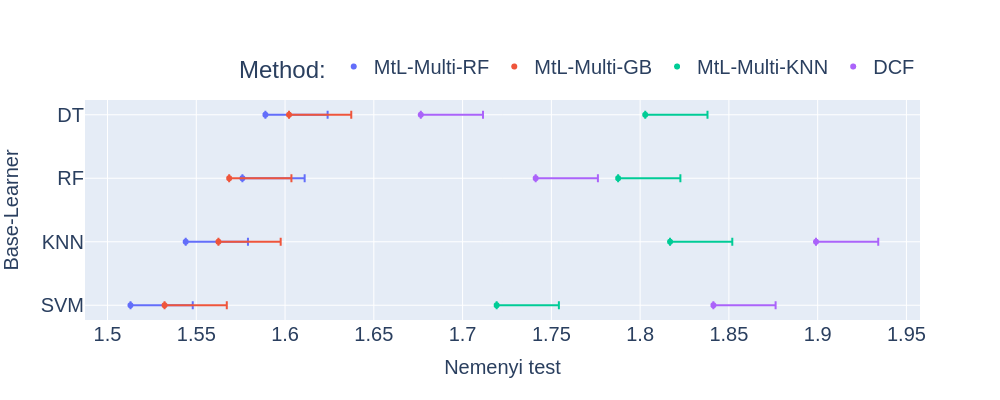

In [19]:
plotNemenyiGraph( df.iloc[[3,2, 1, 0]])

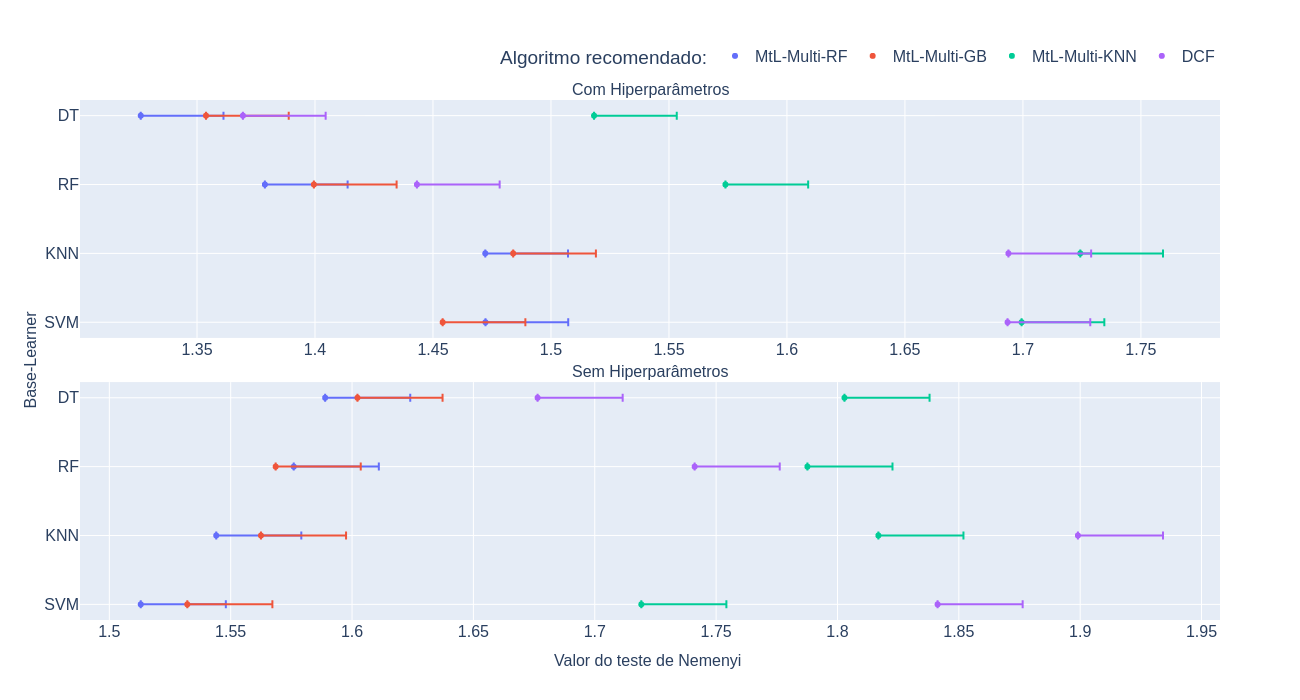

In [20]:
plotNemenyiDualGraph(df1.iloc[[3,2, 1, 0]], df.iloc[[3,2, 1, 0]])